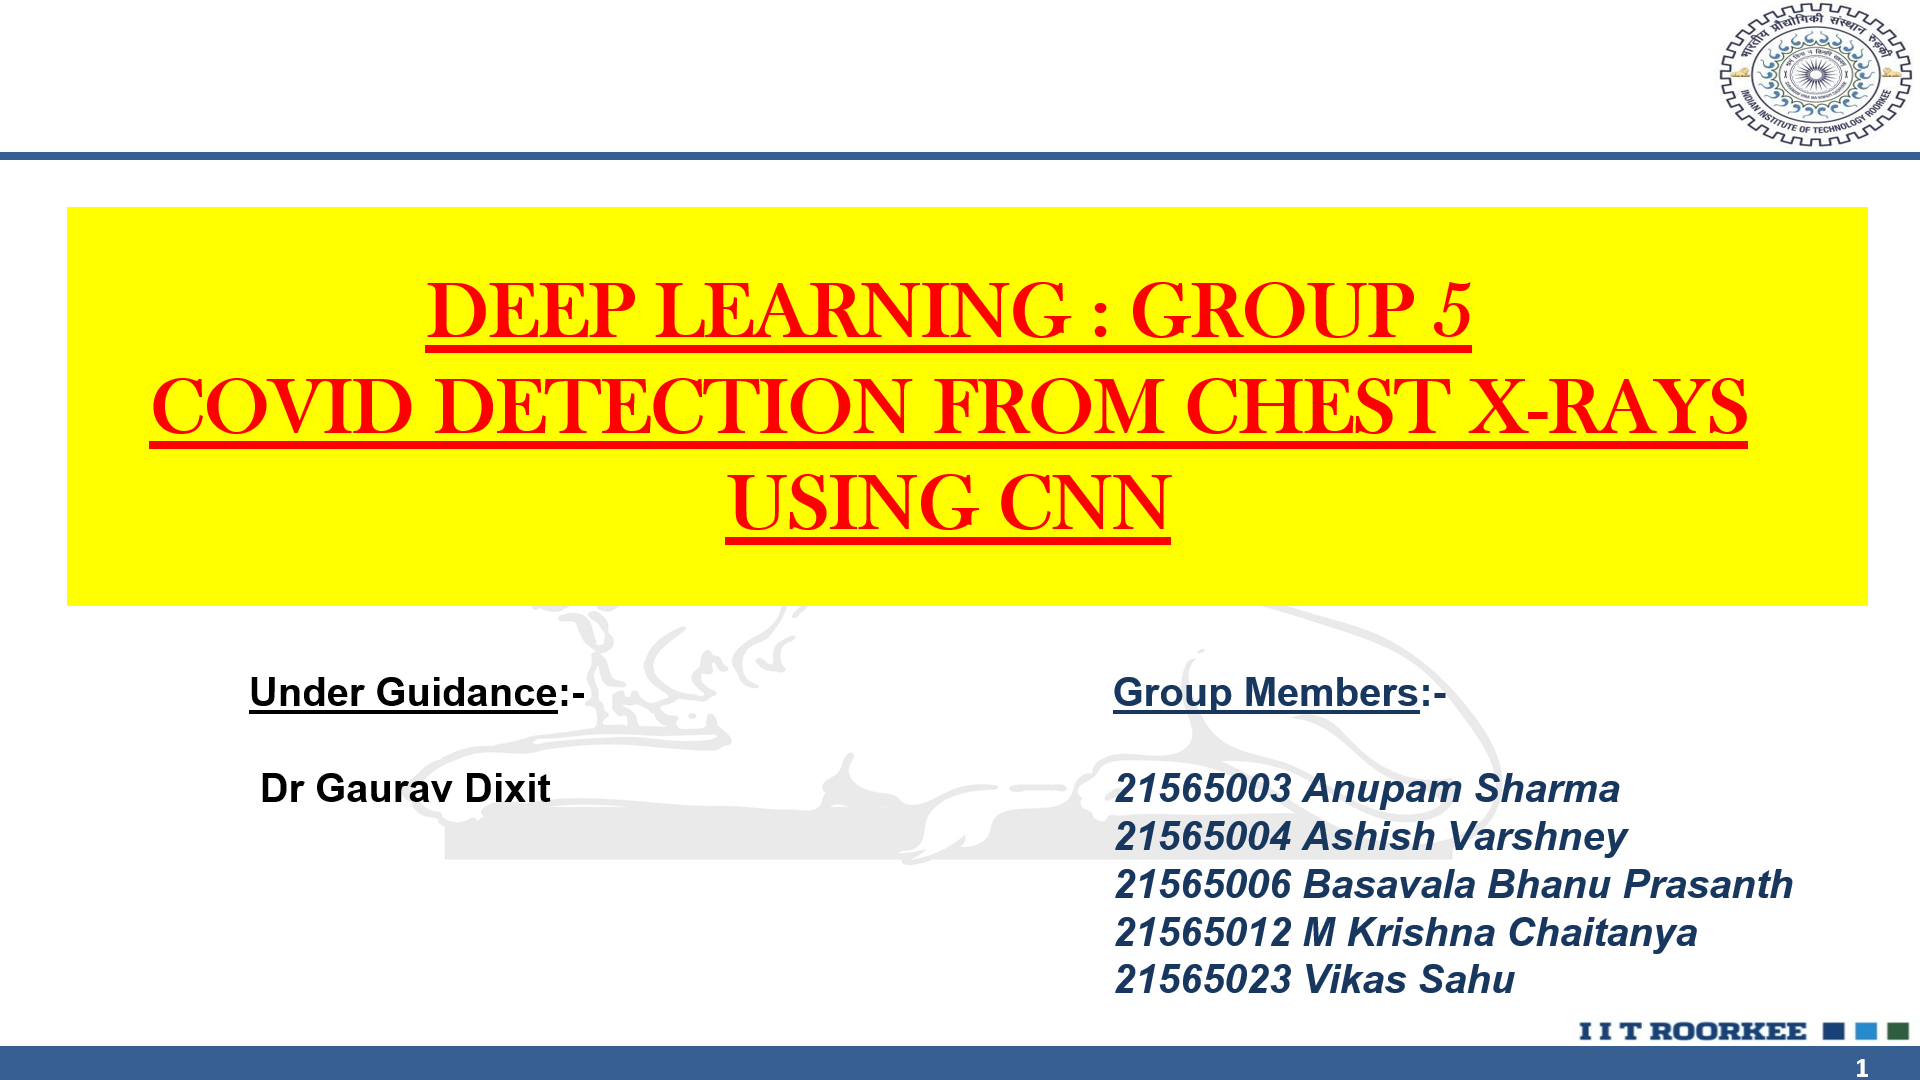

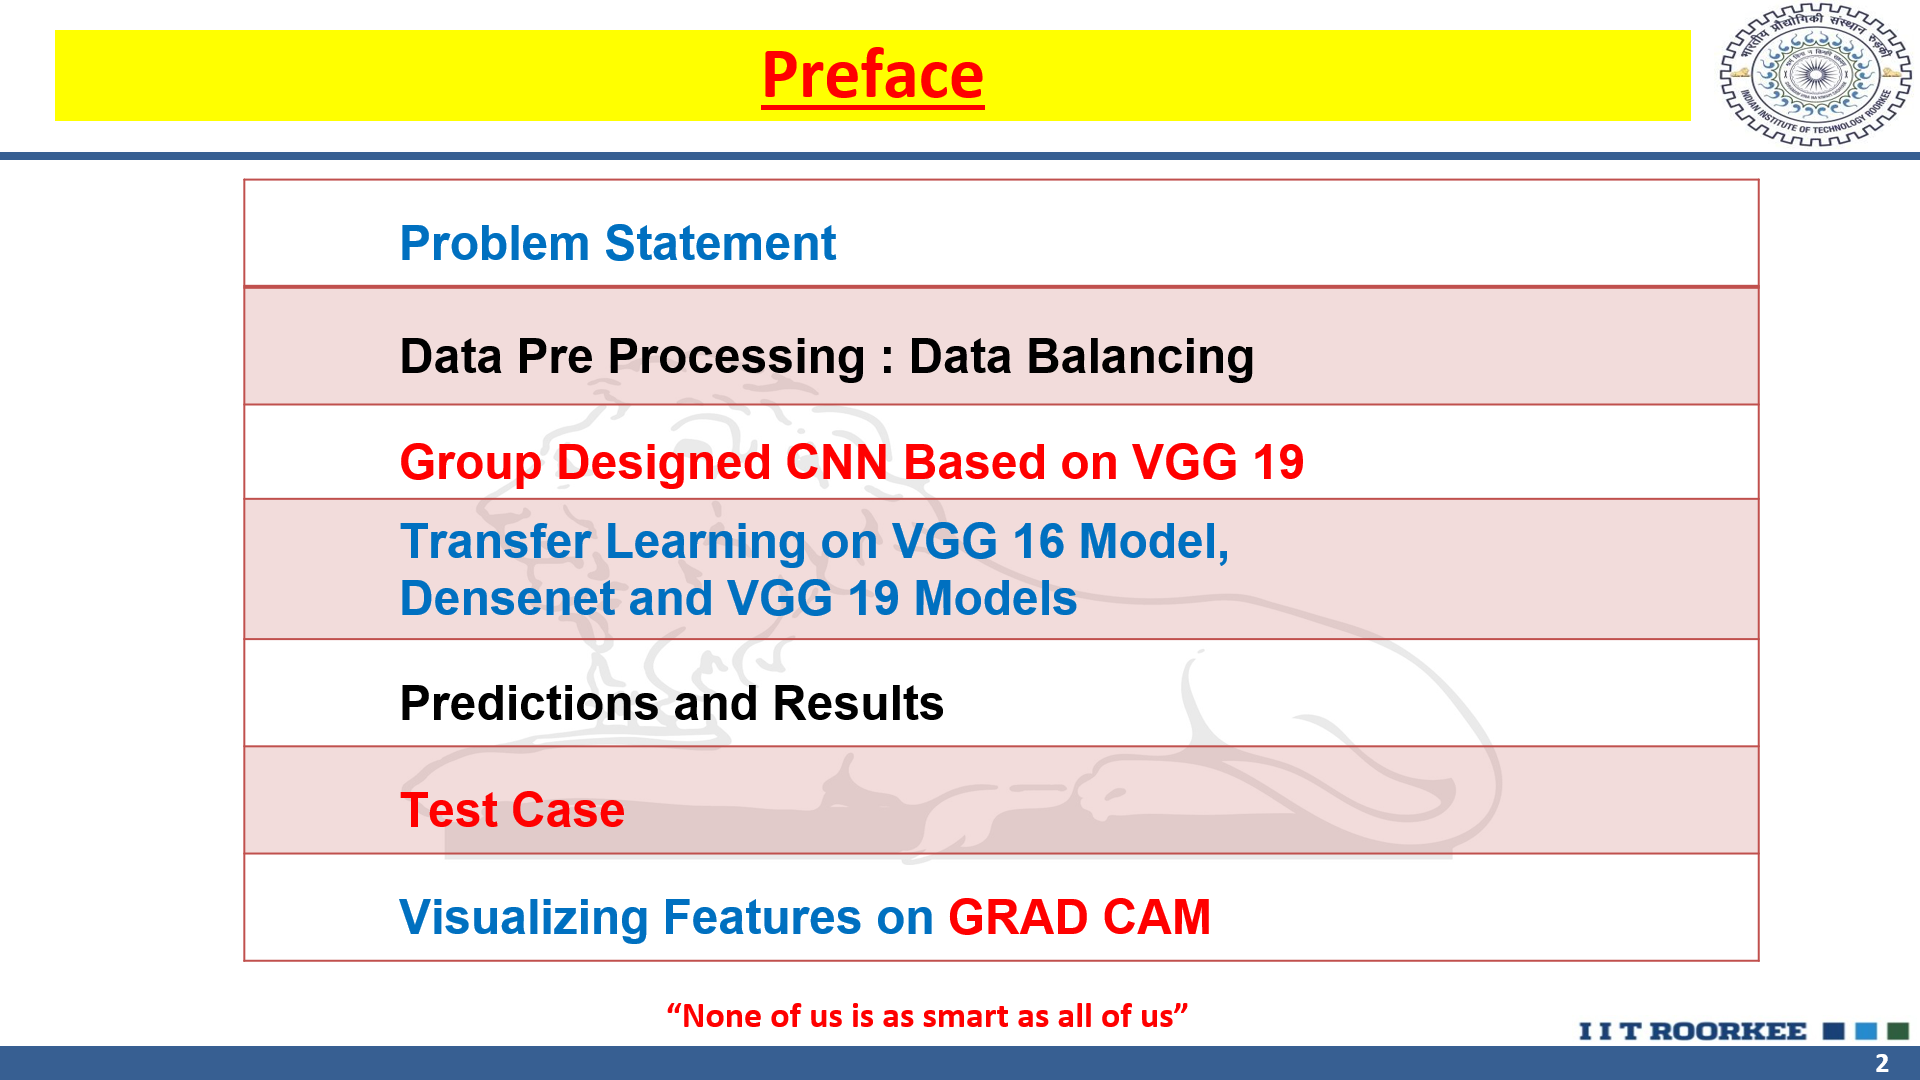

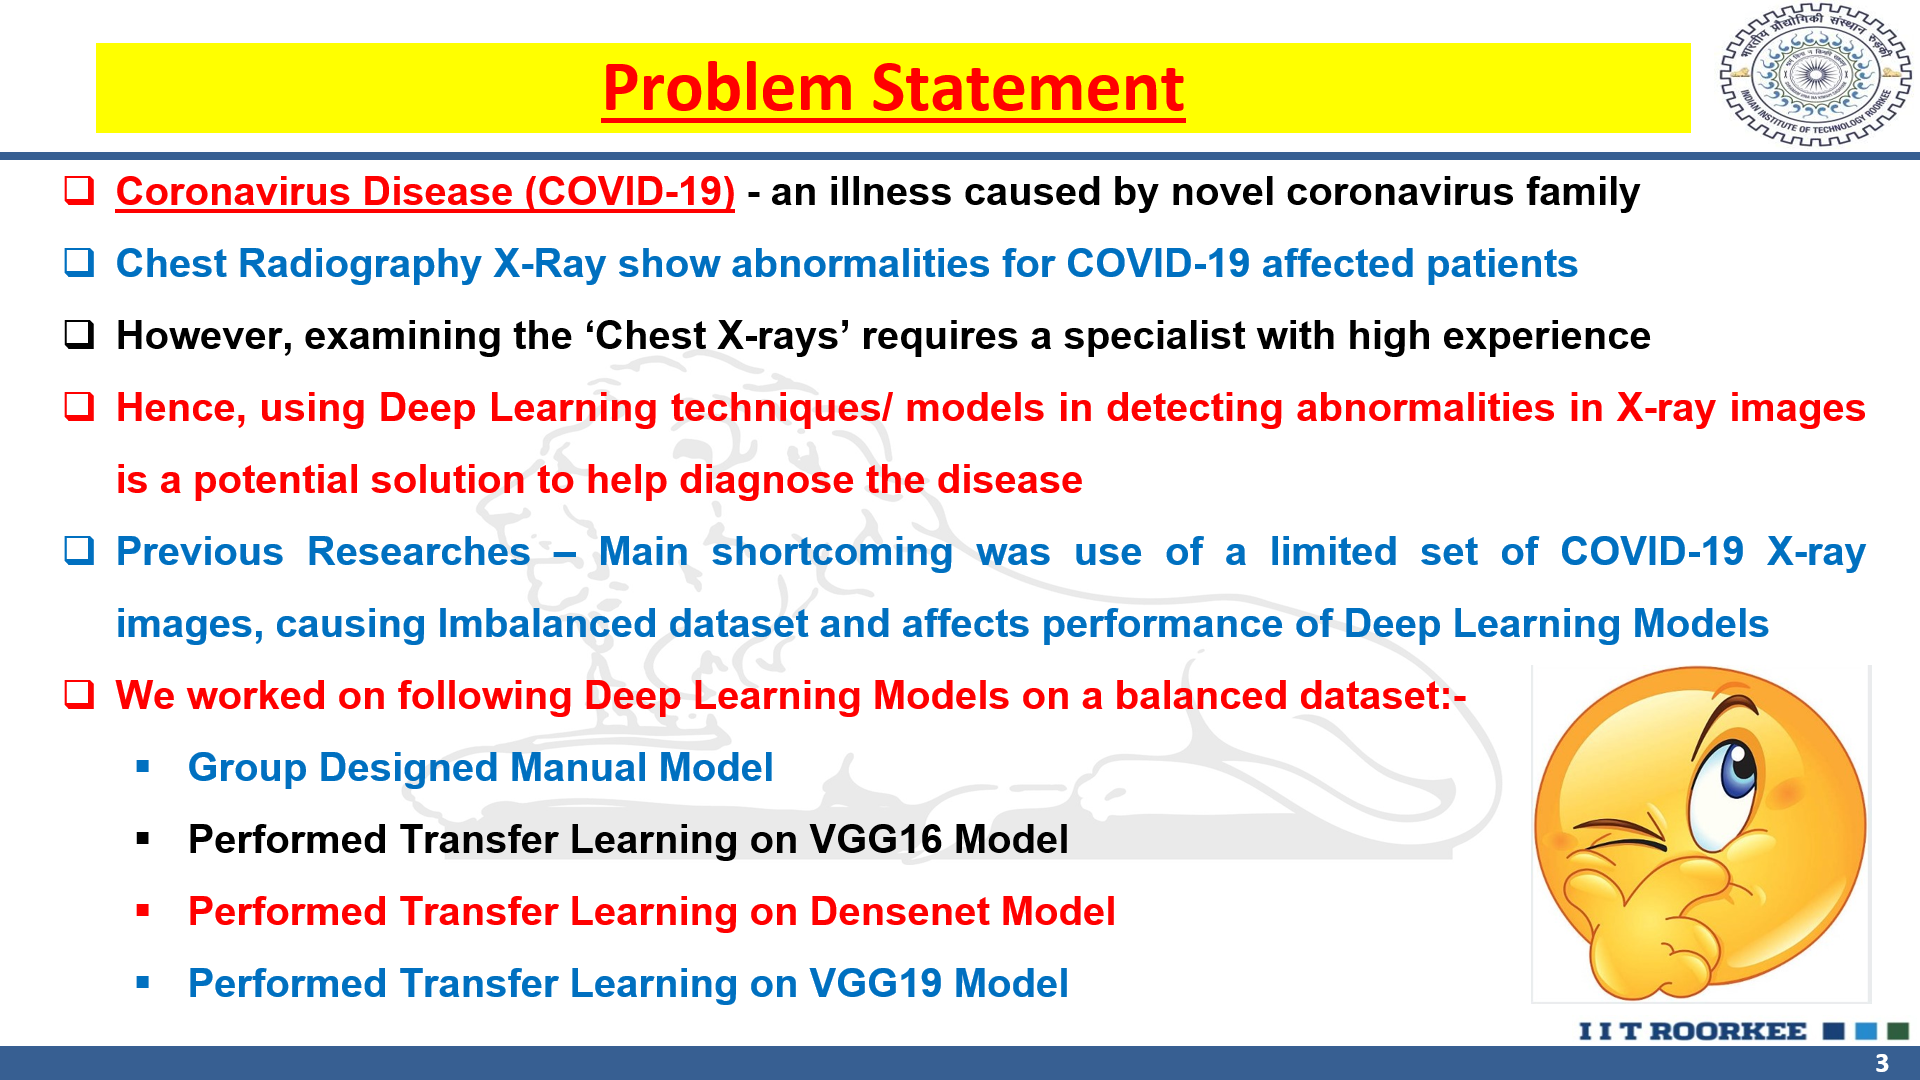

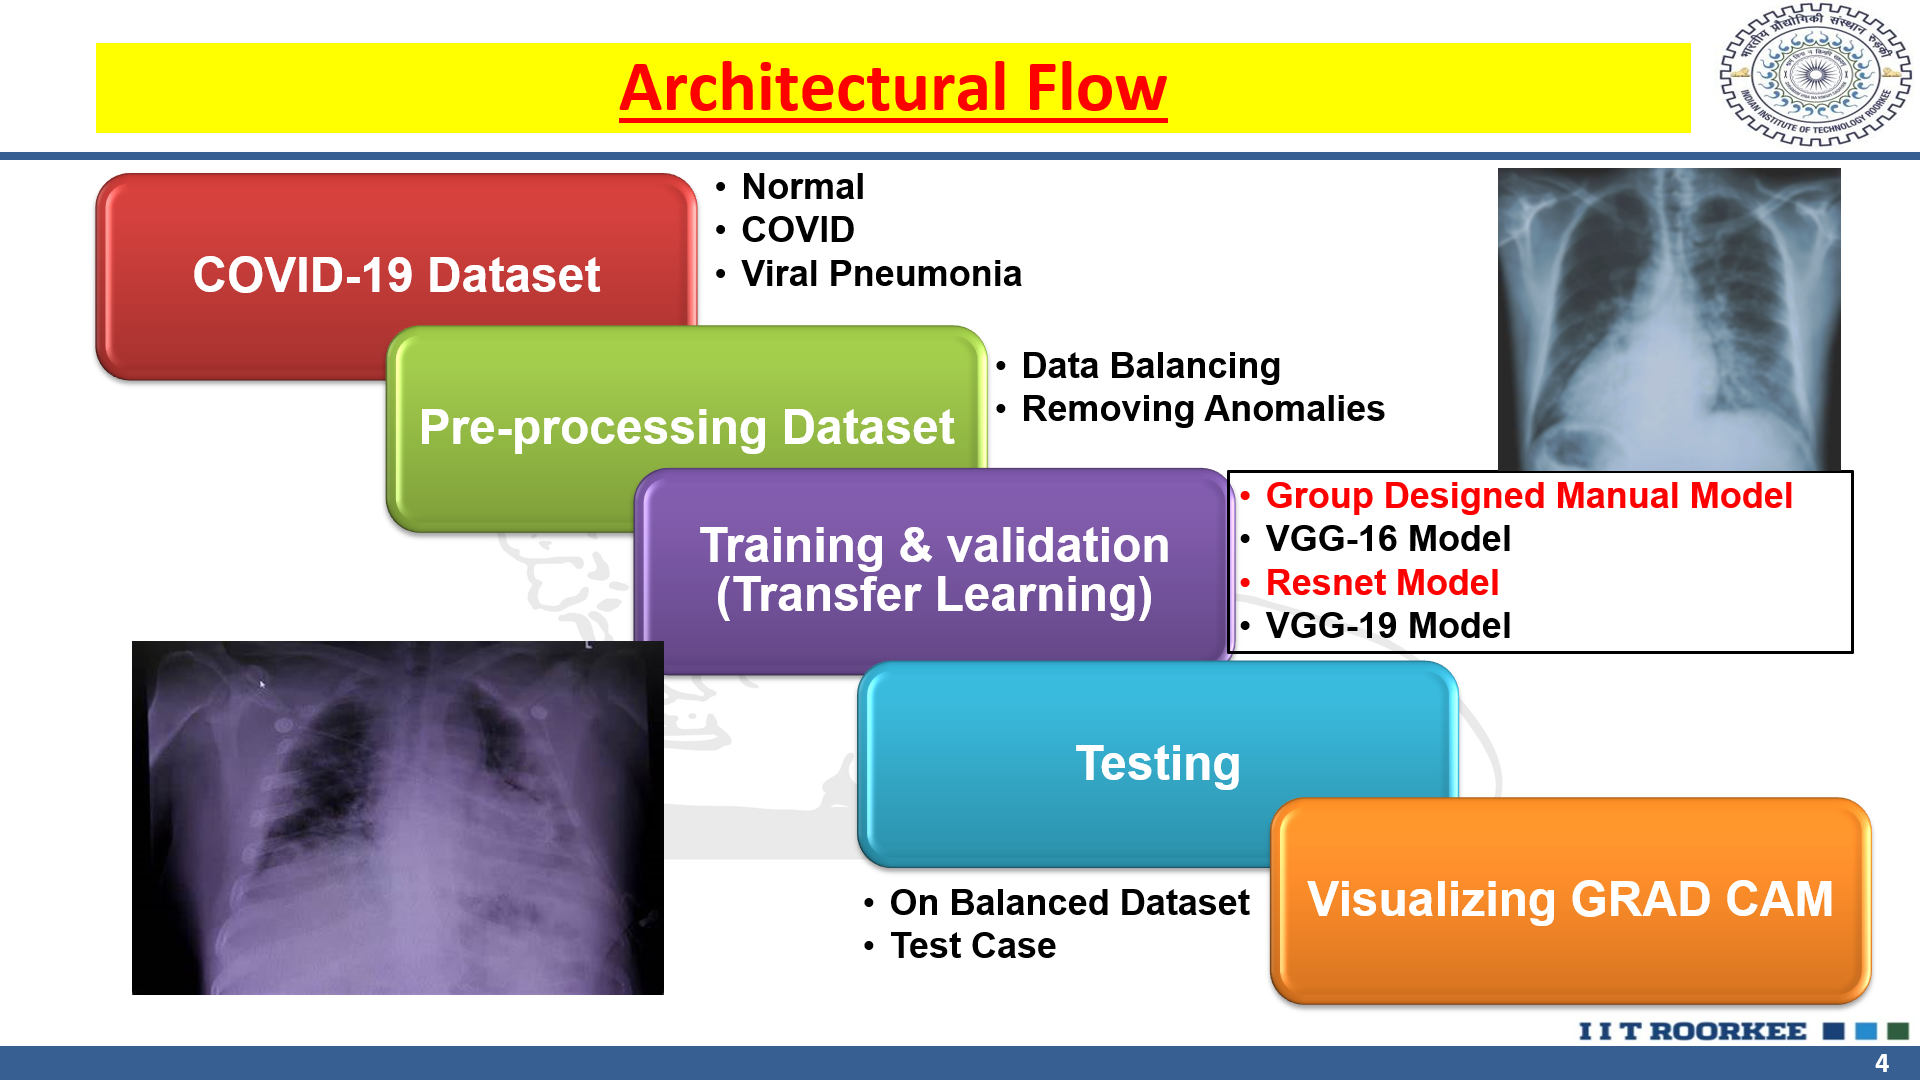

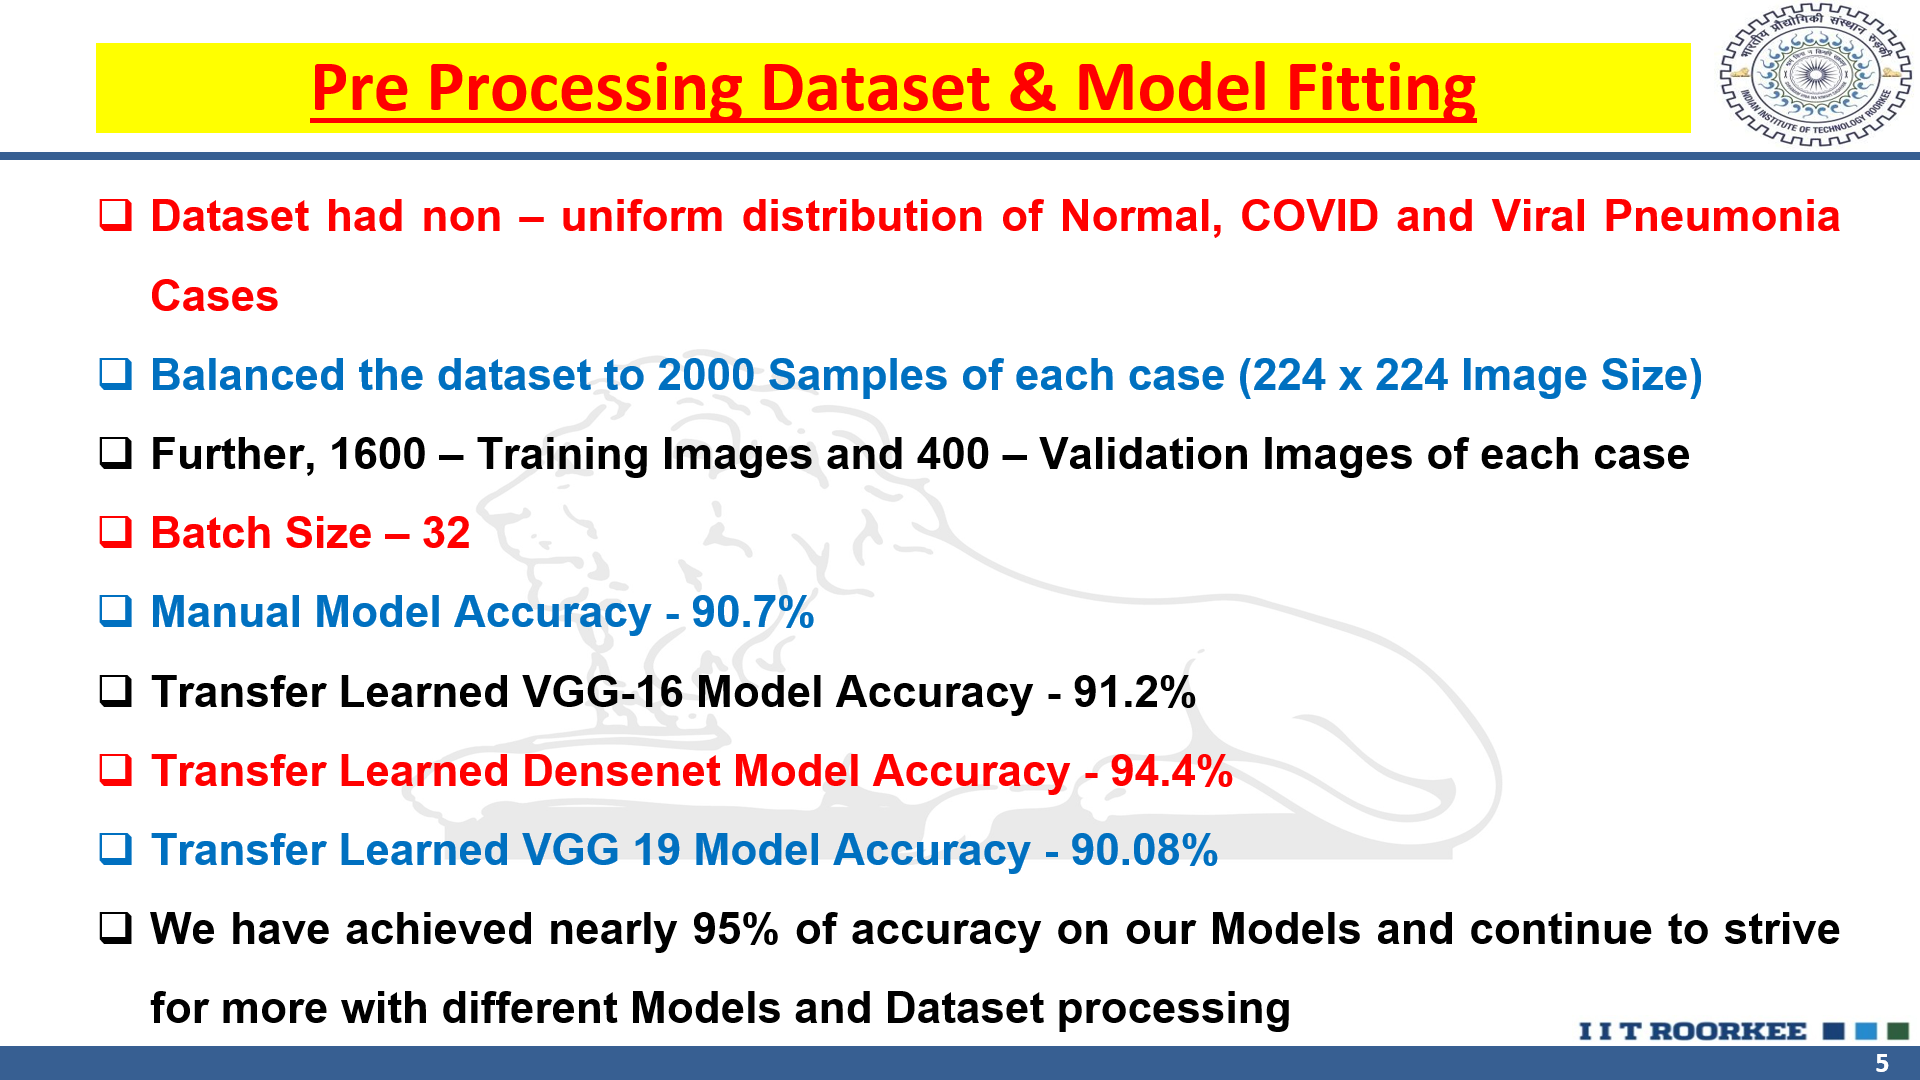

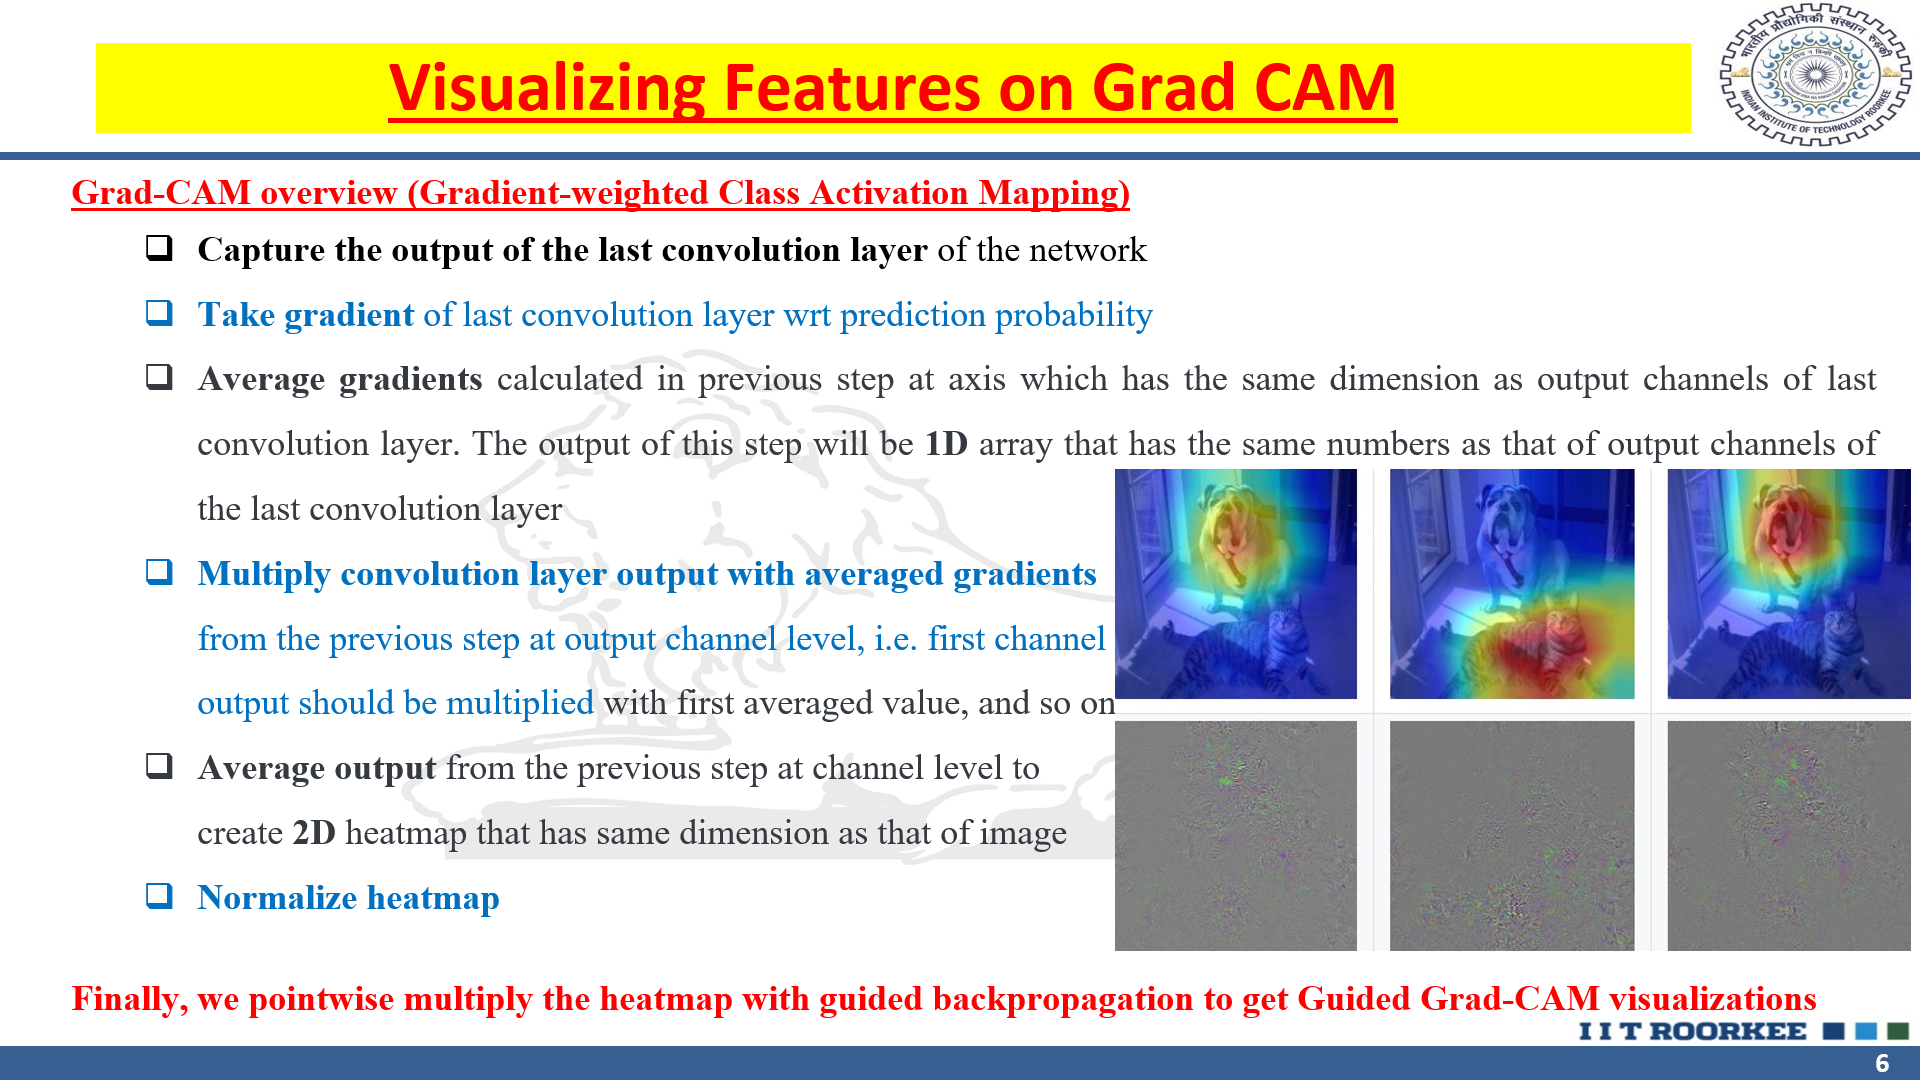

In [46]:
import os      
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, DenseNet201
#from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input,MaxPooling2D,Conv2D
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import argparse
import tensorflow as tf
import tensorflow.keras.layers as tfl
# import Augmentor
import cv2
# from google.colab.patches import cv2_imshow
import pandas as pd
import shutil
import random
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
# to ignore the warnings 
import warnings
warnings.filterwarnings("ignore")
from random import sample

# Accessing Data

In [47]:
normal = 'COVID-ChestXray-15k-dataset/NORMAL'
PNEUMONIA = 'COVID-ChestXray-15k-dataset/PNEUMONIA'
covid = 'COVID-ChestXray-15k-dataset/COVID'
# Path list
dir_normal = os.listdir(normal)
dir_PNEUMONIA = os.listdir(PNEUMONIA)
dir_covid = os.listdir(covid)

# Processing Data

In [48]:
SAMPLE_SIZE = 2000

df_0 = sample(dir_normal,SAMPLE_SIZE)
df_1 = sample(dir_PNEUMONIA,SAMPLE_SIZE)
df_2 = sample(dir_covid,SAMPLE_SIZE)



In [49]:
len(df_0)

2000

In [50]:
len(df_1)

2000

In [51]:
len(df_2)

2000

In [52]:
df_0[0]

'Normal-789.png'

In [53]:
data = []
labels = []
for file_name in df_0:
  label = 1
  data.append(file_name)
  labels.append(label)

In [54]:
len(data)

2000

In [55]:
len(labels)

2000

In [56]:
data_1 = []
labels_1 = []
for file_name in df_1:
  label = 2
 
  data_1.append(file_name)
  labels_1.append(label)

In [57]:
data_2 = []
labels_2 = []
for file_name in df_2:
  label = 0
 
  data_2.append(file_name)
  labels_2.append(label)

In [58]:
dataset = np.concatenate((data, data_1, data_2), axis=0)
label = np.concatenate((labels, labels_1, labels_2), axis=0)

In [59]:
# dictionary of lists 
dict = {'FILE NAME': dataset, 'label': label} 
    
df = pd.DataFrame(dict)

In [60]:
df['label'].value_counts()

1    2000
2    2000
0    2000
Name: label, dtype: int64

In [61]:
data = shuffle(df)
data.head()

FILE NAME  label
3268    Viral Pneumonia-663.png      2
256   NORMAL2-IM-0840-0001.jpeg      1
1359  NORMAL2-IM-0954-0001.jpeg      1
2959    Viral Pneumonia-785.png      2
2989   person320_virus_647.jpeg      2

In [62]:
df_train, df_val = train_test_split(data, test_size=0.20, random_state=26, stratify=data['label'])

print(df_train.shape)
print(df_val.shape)

(4800, 2)
(1200, 2)


In [63]:
df_train['label'].value_counts()

2    1600
1    1600
0    1600
Name: label, dtype: int64

In [64]:
df_val['label'].value_counts()

0    400
1    400
2    400
Name: label, dtype: int64

In [65]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
train_covid = os.path.join(train_dir, 'covid')
os.mkdir(train_covid)
train_normal = os.path.join(train_dir, 'normal')
os.mkdir(train_normal)
train_viral_pneumonia = os.path.join(train_dir, 'viral pneumonia')
os.mkdir(train_viral_pneumonia)

# create new folders inside val_dir
val_covid = os.path.join(val_dir, 'covid')
os.mkdir(val_covid)
val_normal = os.path.join(val_dir, 'normal')
os.mkdir(val_normal)
val_viral_pneumonia = os.path.join(val_dir, 'viral pneumonia')
os.mkdir(val_viral_pneumonia)

In [66]:
# check the folders in train_dir
os.listdir('base_dir/train_dir')

['viral pneumonia', 'normal', 'covid']

In [67]:
os.listdir('base_dir/val_dir')

['viral pneumonia', 'normal', 'covid']

In [68]:
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])

In [69]:
# Copy images to train_dir folder
for filename in train_list:
    
    # add .png extension 
    # filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == filename, ['label']].values)
    
    # # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        # filename = filename.capitalize()
        src = os.path.join(covid, filename)

    if target == 1:
        label = 'normal'
        src = os.path.join(normal, filename)
      
    if target == 2:
        label = 'viral pneumonia'
        src = os.path.join(PNEUMONIA, filename)     
        
    # if target == 2:
    #     label = 'viral pneumonia'
    #     src = os.path.join(PNEUMONIA, filename)
  
    # destination path to image
    dst = os.path.join(train_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

# Copy images to val_dir folder
for filename in val_list:
    
    # add .png extension 
    # filename = image + '.png'
    # get the label for a certain image
    target = int(data.loc[data['FILE NAME'] == filename, ['label']].values)
    
    # # match the target with the folder's name and source path of the image
    if target == 0:
        label = 'covid'
        # As 'FILE NAME's in .xlsx file begins with 'NORMAL' but real file names begin with 'Normal'
        # filename = filename.capitalize()
        src = os.path.join(covid, filename)

    if target == 1:
        label = 'normal'
        src = os.path.join(normal, filename)
      
    if target == 2:
        label = 'viral pneumonia'
        src = os.path.join(PNEUMONIA, filename)     
  
    # destination path to image
    dst = os.path.join(val_dir, label, filename)
    
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [70]:
# check the number of train images in each folder
print(len(os.listdir('base_dir/train_dir/covid')))
print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/viral pneumonia')))

1600
1600
1600


In [71]:
# check the number of validation images in each folder
print(len(os.listdir('base_dir/val_dir/covid')))
print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/viral pneumonia')))

400
400
400


In [72]:
BATCH_SIZE = 32
IMG_SIZE = (224  , 224)
train_directory = "base_dir/train_dir"
val_directory = "base_dir/val_dir"

In [76]:
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=0.2,
        shear_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=IMG_SIZE,
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_directory,
        target_size=IMG_SIZE,
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 4800 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [77]:
# check classes in train_generator
train_generator.class_indices

{'covid': 0, 'normal': 1, 'viral pneumonia': 2}

In [78]:
train_generator.next()[0].shape

(32, 224, 224, 3)

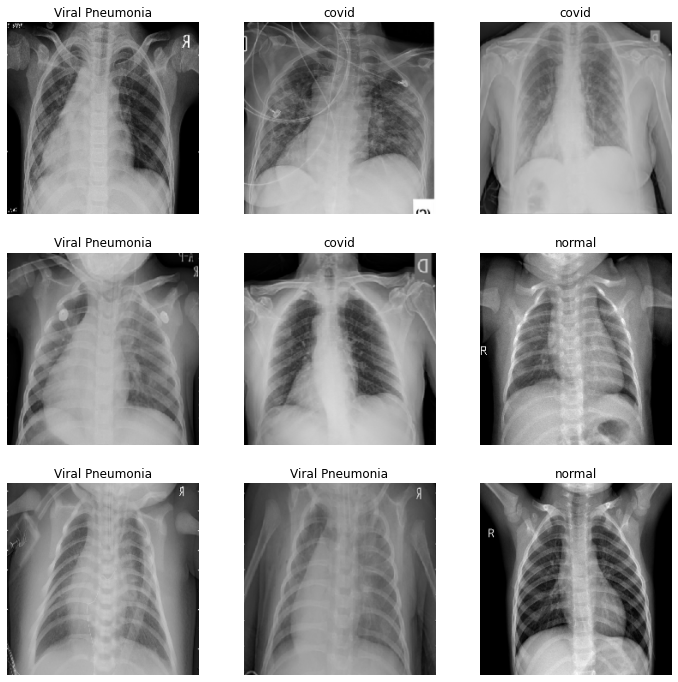

In [79]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = train_generator.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'covid', 1:'normal', 2:'Viral Pneumonia'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

# Manual CNN

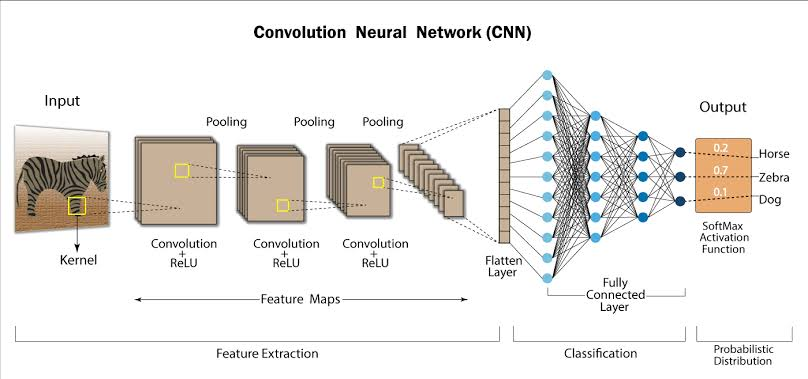

In [175]:
from IPython.display import Video

Video("bhanu2.mp4")

In [132]:
def covid_model1():
    # input_shape = IMG_SIZE + (1, )
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding='same',input_shape=(224,224,3)),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"), 
        Conv2D(32, (3, 3), padding='same', activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"), 
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"),
        Conv2D(64, (3, 3), padding='same',activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"),
        Conv2D(128, (3, 3), padding='same',activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"),
        Conv2D(256, (3, 3), padding='same',activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2),strides=2, padding="same"),
        Flatten(),
       
        Dense(units=128, activation='relu'),
        Dropout(0.25),
        Dense(units=64, activation='relu'),
        Dense(units=3, activation='softmax')
    ])
    return model

In [133]:
model1 = covid_model1()

In [134]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization_9 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                      

In [135]:
base_learning_rate = 0.001
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [136]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [137]:
initial_epochs = 15
history = model1.fit(train_generator, epochs=initial_epochs, 
                     validation_data = validation_generator, callbacks=[early_stopping])

Epoch 1/15


2022-04-13 02:15:10.278023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8398

2022-04-13 02:16:11.891661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 73s 480ms/step - loss: 0.4394 - accuracy: 0.8398 - val_loss: 1.3140 - val_accuracy: 0.3450
Epoch 2/15
150/150 [==============================] - 73s 485ms/step - loss: 0.2874 - accuracy: 0.8960 - val_loss: 1.4329 - val_accuracy: 0.5000
Epoch 3/15
150/150 [==============================] - 73s 487ms/step - loss: 0.2419 - accuracy: 0.9112 - val_loss: 0.8947 - val_accuracy: 0.7125
Epoch 4/15
150/150 [==============================] - 73s 489ms/step - loss: 0.1980 - accuracy: 0.9275 - val_loss: 0.4974 - val_accuracy: 0.8117
Epoch 5/15
150/150 [==============================] - 74s 496ms/step - loss: 0.1931 - accuracy: 0.9298 - val_loss: 0.6765 - val_accuracy: 0.7508
Epoch 6/15
150/150 [==============================] - 74s 492ms/step - loss: 0.1722 - accuracy: 0.9421 - val_loss: 0.7502 - val_accuracy: 0.7658
Epoch 7/15
150/150 [==============================] - 74s 495ms/step - loss: 0.1607 - accuracy: 0.9429 - val_loss: 0.3295 - val_accuracy: 0.9

In [151]:
# Evaluate the model by getting its final loss and accuracy
model1.evaluate(validation_generator)

38/38 [==============================] - 11s 297ms/step - loss: 0.2492 - accuracy: 0.9067


[0.24915233254432678, 0.9066666960716248]

# Accuracy on Manual CNN is 90.67 %

In [152]:
# create history loss and accuracy function
def plot_loss_acc(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(train_loss))

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_loss, color='b', label='Train')
    plt.plot(epochs, val_loss, color='r', label='Validation')
    plt.legend()
    plt.title('Model Loss')
    
    
    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, color='b', label='Train')
    plt.plot(epochs, val_acc, color='r', label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    
    plt.show()

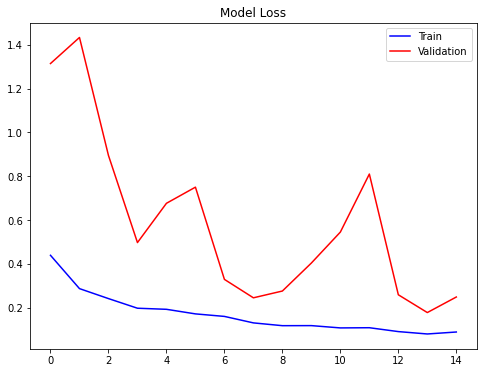

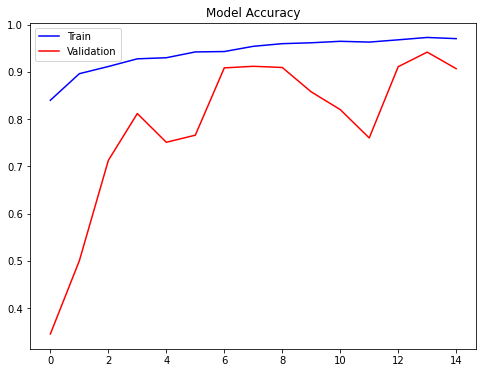

In [153]:
plot_loss_acc(history)

In [154]:
# predict classes of validation dataset
val_predict = model1.predict(validation_generator)

2022-04-13 02:39:42.649479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [155]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()
# len(predict_class)

In [156]:
labels = ['Covid', 'Normal', 'Viral Pneumonia']
report = classification_report(validation_generator.classes, predict_class, target_names=labels)
print(report)

                 precision    recall  f1-score   support

          Covid       0.96      0.91      0.93       400
         Normal       0.92      0.82      0.87       400
Viral Pneumonia       0.85      0.99      0.92       400

       accuracy                           0.91      1200
      macro avg       0.91      0.91      0.91      1200
   weighted avg       0.91      0.91      0.91      1200



In [157]:
cm = confusion_matrix(validation_generator.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL','VIRAL PNEUMONIA'], 
                     columns = ['COVID','NORMAL','VIRAL PNEUMONIA'])

In [158]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

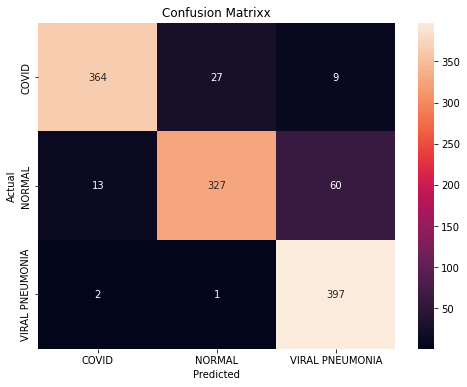

In [159]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Transfer Learning
## VGG16

In [96]:
# initialize the initial learning rate, number of epochs, and batch size
INIT_LR = 1e-3
EPOCHS = 15
BS = 32
baseModel = VGG16(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
# baseModel_1 = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# baseModel_2= DenseNet201(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model_vgg16 = Model(inputs=baseModel.input, outputs=headModel)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

for layer in baseModel.layers:
    layer.trainable = False

In [97]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_vgg16.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
H = model_vgg16.fit(train_generator, validation_data=validation_generator,batch_size = BS, epochs=EPOCHS,callbacks=callbacks)

Epoch 1/15


2022-04-13 01:25:24.788437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 0.7807 - accuracy: 0.6735

2022-04-13 01:26:30.368987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 82s 541ms/step - loss: 0.7807 - accuracy: 0.6735 - val_loss: 0.5165 - val_accuracy: 0.8208
Epoch 2/15
150/150 [==============================] - 82s 546ms/step - loss: 0.4685 - accuracy: 0.8317 - val_loss: 0.3780 - val_accuracy: 0.8592
Epoch 3/15
150/150 [==============================] - 82s 549ms/step - loss: 0.3840 - accuracy: 0.8669 - val_loss: 0.3372 - val_accuracy: 0.8683
Epoch 4/15
150/150 [==============================] - 82s 547ms/step - loss: 0.3540 - accuracy: 0.8673 - val_loss: 0.3415 - val_accuracy: 0.8842
Epoch 5/15
150/150 [==============================] - 82s 547ms/step - loss: 0.3222 - accuracy: 0.8856 - val_loss: 0.3287 - val_accuracy: 0.8733
Epoch 6/15
150/150 [==============================] - 82s 544ms/step - loss: 0.3049 - accuracy: 0.8927 - val_loss: 0.3738 - val_accuracy: 0.8558
Epoch 7/15
150/150 [==============================] - 82s 545ms/step - loss: 0.2854 - accuracy: 0.8975 - val_loss: 0.3326 - val_accuracy: 0.8

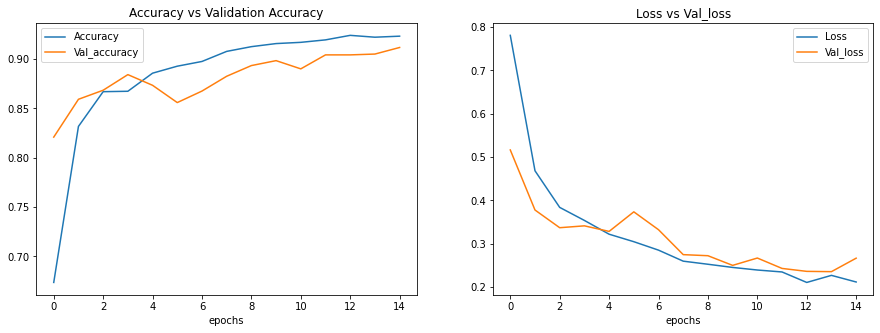

In [98]:
acc = H.history['accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
val_acc = H.history['val_accuracy']
epochs = range(len(H.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Accuracy', 'Val_accuracy']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
plt.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
plt.show()

In [160]:
# Evaluate the model by getting its final loss and accuracy
model_vgg16.evaluate(validation_generator)

38/38 [==============================] - 17s 421ms/step - loss: 0.2669 - accuracy: 0.9117


[0.2669197916984558, 0.9116666913032532]

# VGG16 Accuracy is 91.17

## Densenet

In [161]:
# initialize the initial learning rate, number of epochs, and batch size
INIT_LR = 1e-3
EPOCHS = 15
BS = 32
# baseModel = VGG16(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
# baseModel_1 = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
baseModel_2= DenseNet201(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
headModel = baseModel_2.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model_Densenet = Model(inputs=baseModel_2.input, outputs=headModel)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),ModelCheckpoint(filepath='best_model_dense.h5', monitor='val_loss', save_best_only=True)]

for layer in baseModel.layers:
    layer.trainable = False

In [162]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_Densenet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
H1 = model_Densenet.fit(train_generator, validation_data=validation_generator,batch_size = BS, epochs=EPOCHS,callbacks=callbacks)

Epoch 1/15


2022-04-13 02:43:01.206615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7944

2022-04-13 02:45:27.353806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 170s 1s/step - loss: 0.5348 - accuracy: 0.7944 - val_loss: 3.6166 - val_accuracy: 0.6342
Epoch 2/15
150/150 [==============================] - 152s 1s/step - loss: 0.2671 - accuracy: 0.9062 - val_loss: 0.5166 - val_accuracy: 0.8367
Epoch 3/15
150/150 [==============================] - 149s 992ms/step - loss: 0.2180 - accuracy: 0.9210 - val_loss: 0.8063 - val_accuracy: 0.8308
Epoch 4/15
150/150 [==============================] - 151s 1s/step - loss: 0.2107 - accuracy: 0.9279 - val_loss: 0.2593 - val_accuracy: 0.9233
Epoch 5/15
150/150 [==============================] - 153s 1s/step - loss: 0.1513 - accuracy: 0.9477 - val_loss: 0.2221 - val_accuracy: 0.9217
Epoch 6/15
150/150 [==============================] - 149s 990ms/step - loss: 0.1461 - accuracy: 0.9531 - val_loss: 0.5131 - val_accuracy: 0.7850
Epoch 7/15
150/150 [==============================] - 148s 982ms/step - loss: 0.1206 - accuracy: 0.9556 - val_loss: 0.2228 - val_accuracy: 0.9342
E

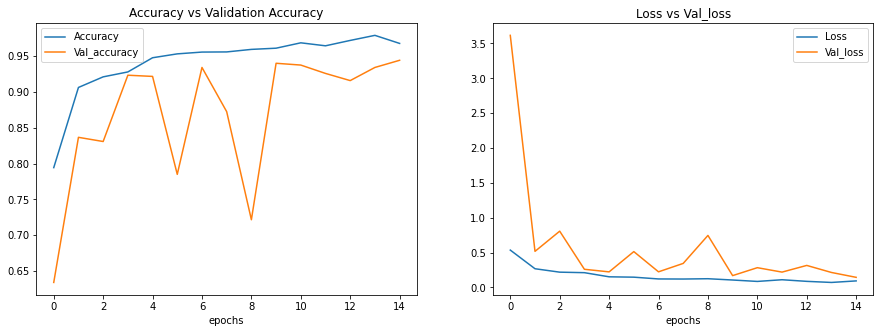

In [165]:
acc_dense = H1.history['accuracy']
loss_dense = H1.history['loss']
val_loss_dense = H1.history['val_loss']
val_acc_dense = H1.history['val_accuracy']
epochs_dense = range(len(H1.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Accuracy', 'Val_accuracy']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs_dense, acc_dense, val_acc_dense, leg, title):
    plt.plot(epochs_dense, acc_dense)
    plt.plot(epochs_dense, val_acc_dense)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs_dense, acc_dense, val_acc_dense, leg1, title1)
plt.subplot(1,2,2)
plot(epochs_dense, loss_dense, val_loss_dense, leg2, title2)
plt.show()

In [166]:
# Evaluate the model by getting its final loss and accuracy
model_Densenet.evaluate(validation_generator)

38/38 [==============================] - 16s 419ms/step - loss: 0.1437 - accuracy: 0.9442


[0.1436750292778015, 0.9441666603088379]

# Densenet accuracy is 94.4

In [167]:
# initialize the initial learning rate, number of epochs, and batch size
INIT_LR = 1e-3
EPOCHS = 15
BS = 32
# baseModel = VGG16(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
baseModel_1 = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# baseModel_2= DenseNet201(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
headModel = baseModel_1.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model_vgg19 = Model(inputs=baseModel_1.input, outputs=headModel)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),ModelCheckpoint(filepath='best_model_vgg19.h5', monitor='val_loss', save_best_only=True)]

for layer in baseModel_1.layers:
    layer.trainable = False

In [168]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_vgg19.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
H2 = model_vgg19.fit(train_generator, validation_data=validation_generator,batch_size = BS, epochs=EPOCHS,callbacks=callbacks)


Epoch 1/15


2022-04-13 03:21:15.536185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.6431

2022-04-13 03:22:21.930771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 84s 560ms/step - loss: 0.8221 - accuracy: 0.6431 - val_loss: 0.5448 - val_accuracy: 0.8267
Epoch 2/15
150/150 [==============================] - 83s 555ms/step - loss: 0.5372 - accuracy: 0.8035 - val_loss: 0.5336 - val_accuracy: 0.7767
Epoch 3/15
150/150 [==============================] - 84s 560ms/step - loss: 0.4462 - accuracy: 0.8375 - val_loss: 0.4130 - val_accuracy: 0.8358
Epoch 4/15
150/150 [==============================] - 83s 553ms/step - loss: 0.4068 - accuracy: 0.8529 - val_loss: 0.3471 - val_accuracy: 0.8700
Epoch 5/15
150/150 [==============================] - 83s 551ms/step - loss: 0.3681 - accuracy: 0.8665 - val_loss: 0.3113 - val_accuracy: 0.8917
Epoch 6/15
150/150 [==============================] - 83s 551ms/step - loss: 0.3445 - accuracy: 0.8746 - val_loss: 0.2936 - val_accuracy: 0.8967
Epoch 7/15
150/150 [==============================] - 82s 546ms/step - loss: 0.3453 - accuracy: 0.8710 - val_loss: 0.2871 - val_accuracy: 0.9

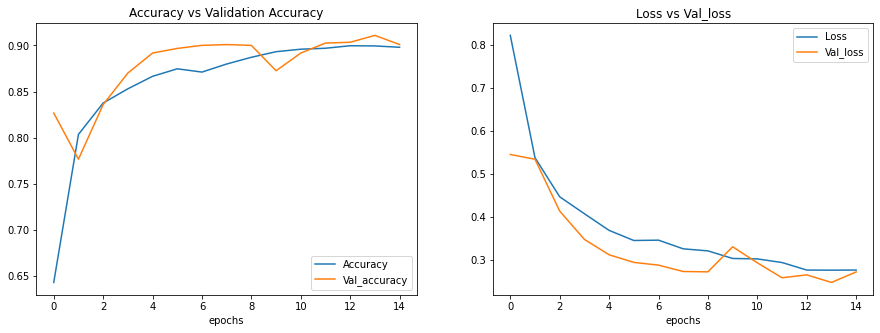

In [169]:
acc_vgg19 = H2.history['accuracy']
loss_vgg19 = H2.history['loss']
val_loss_vgg19 = H2.history['val_loss']
val_acc_vgg19 = H2.history['val_accuracy']
epochs_vgg19 = range(len(H2.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Accuracy', 'Val_accuracy']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs_vgg19, acc_vgg19, val_acc_vgg19, leg, title):
    plt.plot(epochs_vgg19, acc_vgg19)
    plt.plot(epochs_vgg19, val_acc_vgg19)
    plt.title(title)
    plt.legend(leg)
    plt.xlabel('epochs')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot(epochs_vgg19, acc_vgg19, val_acc_vgg19, leg1, title1)
plt.subplot(1,2,2)
plot(epochs_vgg19, loss_vgg19, val_loss_vgg19, leg2, title2)
plt.show()

In [170]:
# Evaluate the model by getting its final loss and accuracy
model_vgg19.evaluate(validation_generator)

38/38 [==============================] - 17s 461ms/step - loss: 0.2713 - accuracy: 0.9008


[0.271335244178772, 0.9008333683013916]

# VGG19 Accuracy is 90.08

# Predictions

In [111]:
from keras.models import load_model
model = load_model("best_model.h5")

In [112]:
# Evaluate the model by getting its final loss and accuracy
model.evaluate(validation_generator)

2022-04-13 01:58:27.211808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 16s 419ms/step - loss: 0.2359 - accuracy: 0.9050


[0.2358618974685669, 0.9050000309944153]

In [141]:
class_type= {0:'covid', 1:'normal', 2: 'viral pneumonia'}

In [142]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)/255
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given X-Ray image is of type = covid

The chances of image being Covid is : 99.13691878318787 percent

The chances of image being Normal is : 0.46186763793230057 percent


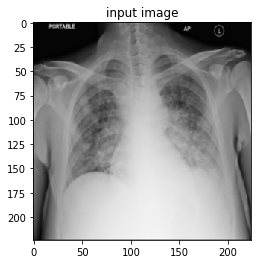

In [143]:
# path for that new image. ( you can take it either from google or any other scource)


path = "/Users/chaitanya/Desktop/Project_deep/all_images/Lung_Opacity-26.png"       # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = class_type[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")

# to display the image  
plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()

# Gradcam

In [144]:
# this function is udes to generate the heat map of aan image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [145]:
import matplotlib.cm as cm

from IPython.display import Image, display

In [146]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
  

    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

#     tf.keras.preprocessing.image
    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [147]:
# function that is used to predict the image type and the ares that are affected by covid


def image_prediction_and_visualization(path,last_conv_layer_name = "block5_conv3", model = model):

  """
  input:  is the image path, name of last convolution layer , model name
  output : returs the predictions and the area that is effected
  """
  
  img_array = get_img_array(path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  plt.title("the heat map of the image is ")
  plt.imshow(heatmap)
  plt.show()
  print()
  img = get_img_array(path)

  res = class_type[np.argmax(model.predict(img))]
  print(f"The given X-Ray image is of type = {res}")
  print()
  print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} %")
  print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} %")

  print()
  print("image with heatmap representing region on interest")

  # function call
  save_and_display_gradcam(path, heatmap)

  print()
  print("the original input image")
  print()

  a = plt.imread(path)
  plt.imshow(a, cmap = "gray")
  plt.title("Original image")
  plt.show()

# Predictions
## Image has been obtained from online resources.
## The prediction results are as below.

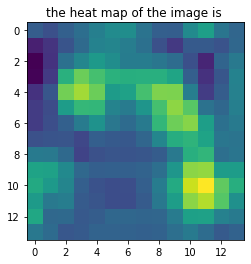


The given X-Ray image is of type = covid

The chances of image being Covid is : 99.95705485343933 %
The chances of image being Normal is : 0.035867790575139225 %

image with heatmap representing region on interest


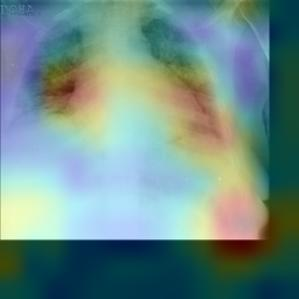


the original input image



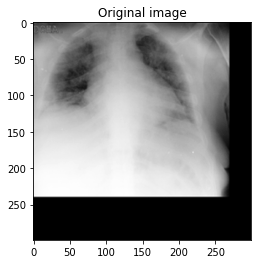

In [148]:
#predictions

path = "/Users/chaitanya/Downloads/COVID-ChestXray-15k-dataset/COVID/COVID-1184.png"

image_prediction_and_visualization(path)

***Normal***

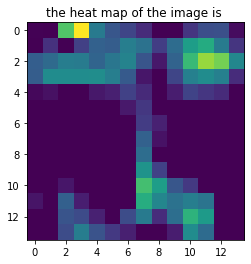


The given X-Ray image is of type = normal

The chances of image being Covid is : 24.80924278497696 %
The chances of image being Normal is : 46.00552022457123 %

image with heatmap representing region on interest


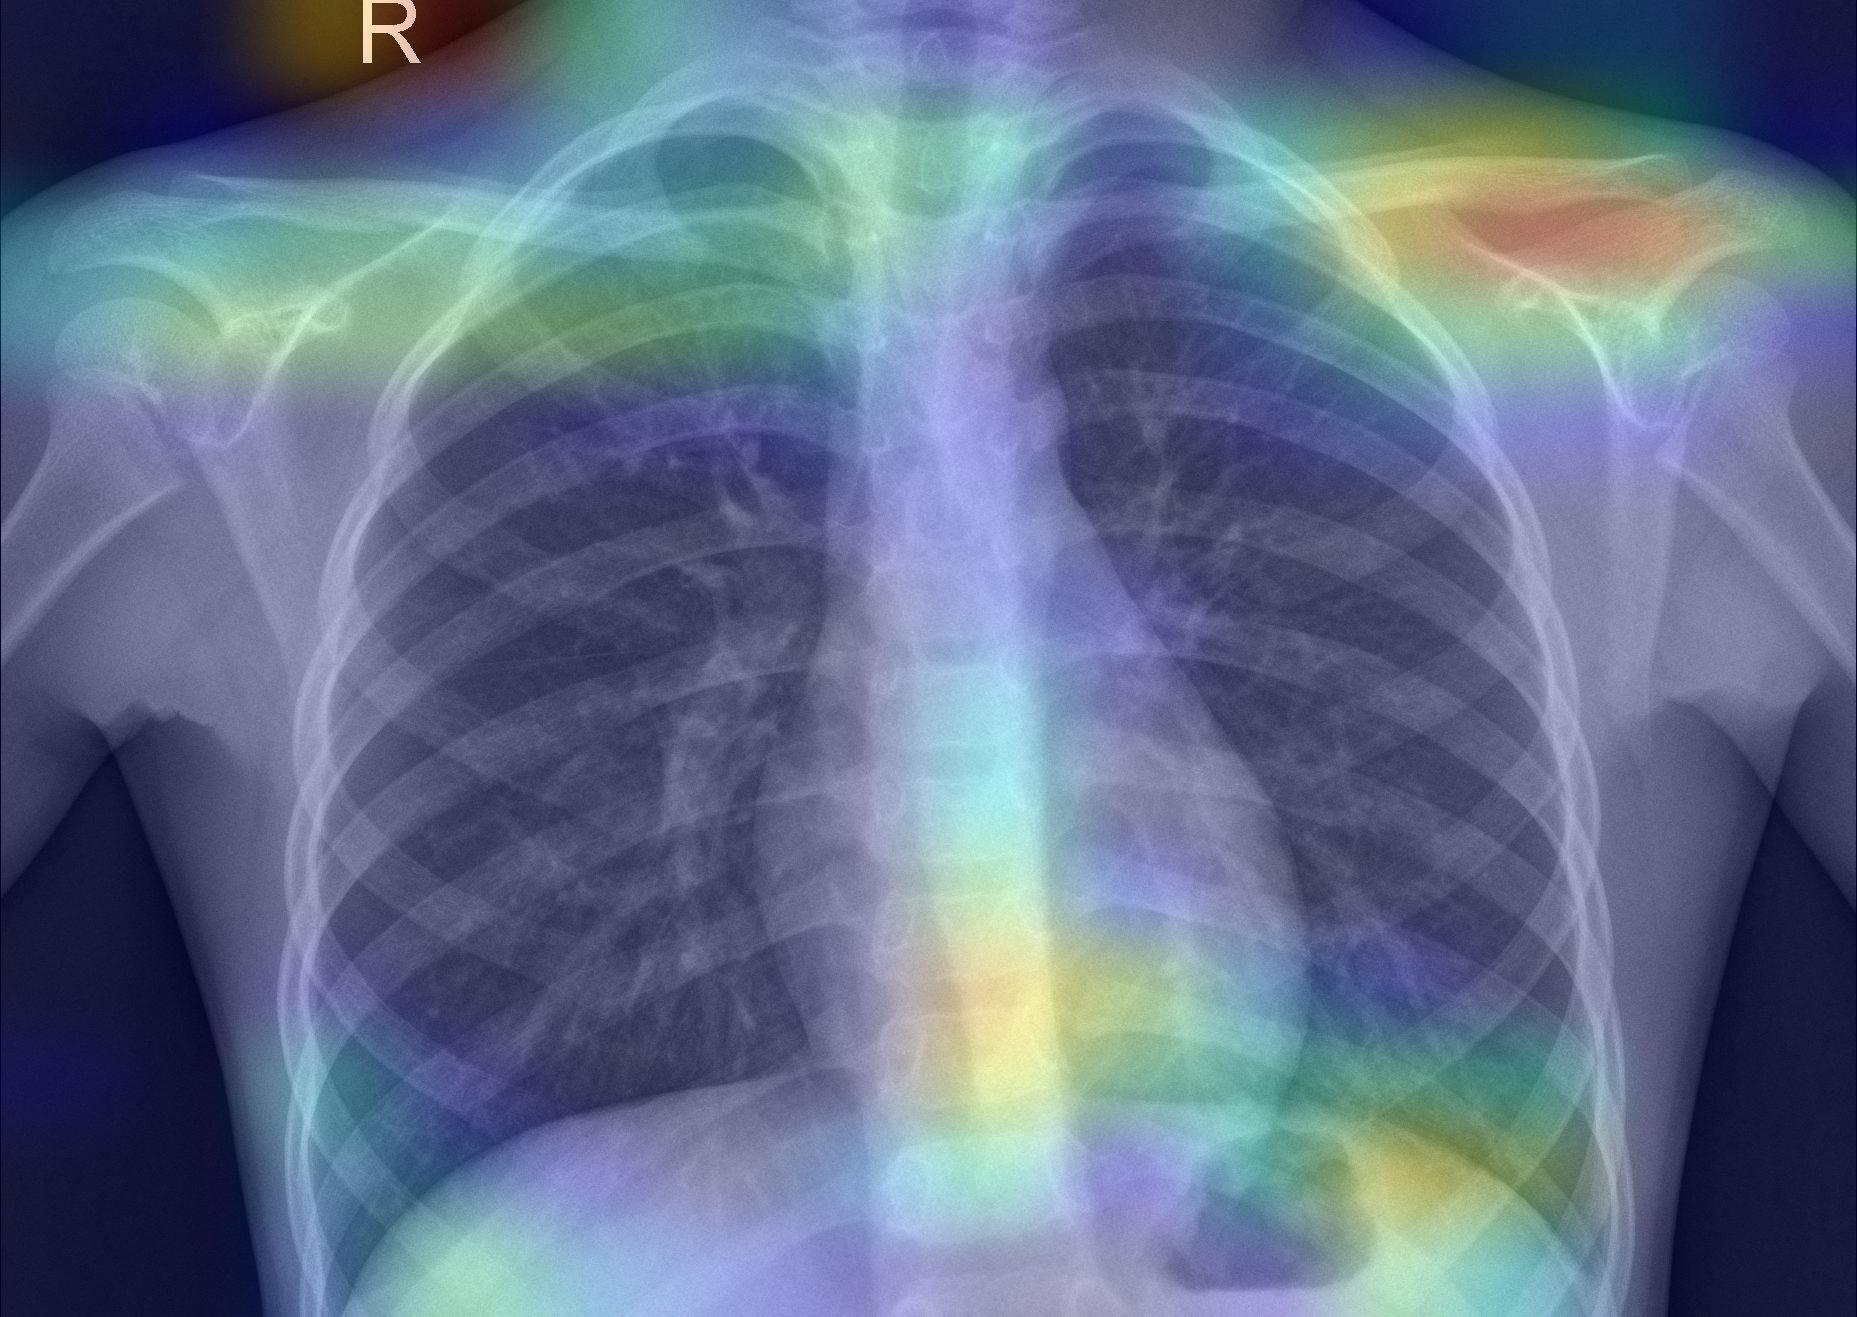


the original input image



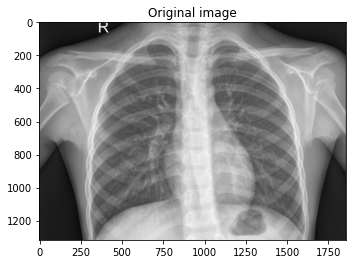

In [149]:
#predictions

path = "/Users/chaitanya/Desktop/covid 15k data/COVID-ChestXray-15k-dataset/NORMAL/IM-0001-0001.jpeg"

image_prediction_and_visualization(path)

***viral Pnemonia***

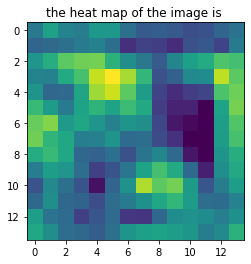


The given X-Ray image is of type = viral pneumonia

The chances of image being Covid is : 0.14051733305677772 %
The chances of image being Normal is : 0.3458363004028797 %

image with heatmap representing region on interest


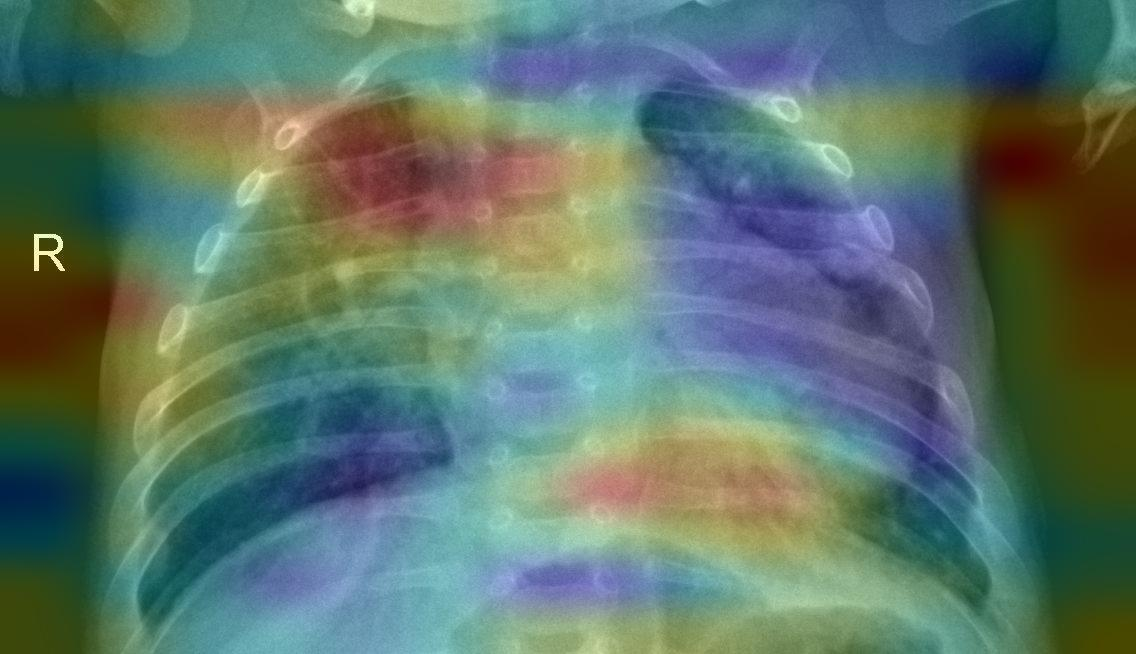


the original input image



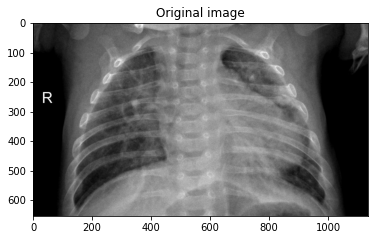

In [150]:
#predictions

path = "/Users/chaitanya/Desktop/covid 15k data/COVID-ChestXray-15k-dataset/PNEUMONIA/person1_virus_13.jpeg"

image_prediction_and_visualization(path)

# Thank you